In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Timestamp
import seaborn as sns

plt.rcParams["figure.figsize"] = (10, 4) 


plt.rcParams["figure.dpi"] = 400

raw = pd.read_csv("USCurves.csv")

MONTH = 'MONTH'
YEAR = 'YEAR'
MONTHS_IN_YEAR = 12
raw.columns

Index(['date', 'BC_1MONTH', 'BC_3MONTH', 'BC_6MONTH', 'BC_1YEAR', 'BC_2YEAR',
       'BC_3YEAR', 'BC_5YEAR', 'BC_7YEAR', 'BC_10YEAR', 'BC_20YEAR',
       'BC_30YEAR', 'BC_30YEARDISPLAY'],
      dtype='object')

In [39]:
column_mutations = {}

In [41]:
for i in range(1, len(raw.columns)-1):
    x = raw.columns[i]
    if YEAR in x or MONTH in x:
        time_str = x[3:]
        if YEAR in x:
            time_str = time_str.split(YEAR)[0]
            time = float(time_str)
        elif MONTH in x:
            time_str = time_str.split(MONTH)[0]
            time_raw = float(time_str) / MONTHS_IN_YEAR
            time = round(time_raw, 2)
        else:
            raise RuntimeError("This branch should never execute")


    column_mutations[raw.columns[i]] = time

In [42]:
new_columns = raw.rename(columns=column_mutations)
yield_curves = new_columns.set_index(pd.to_datetime(new_columns["date"])).drop(["date", "BC_30YEARDISPLAY"], axis=1)

In [43]:
yield_curves.drop(columns=20, inplace=True)

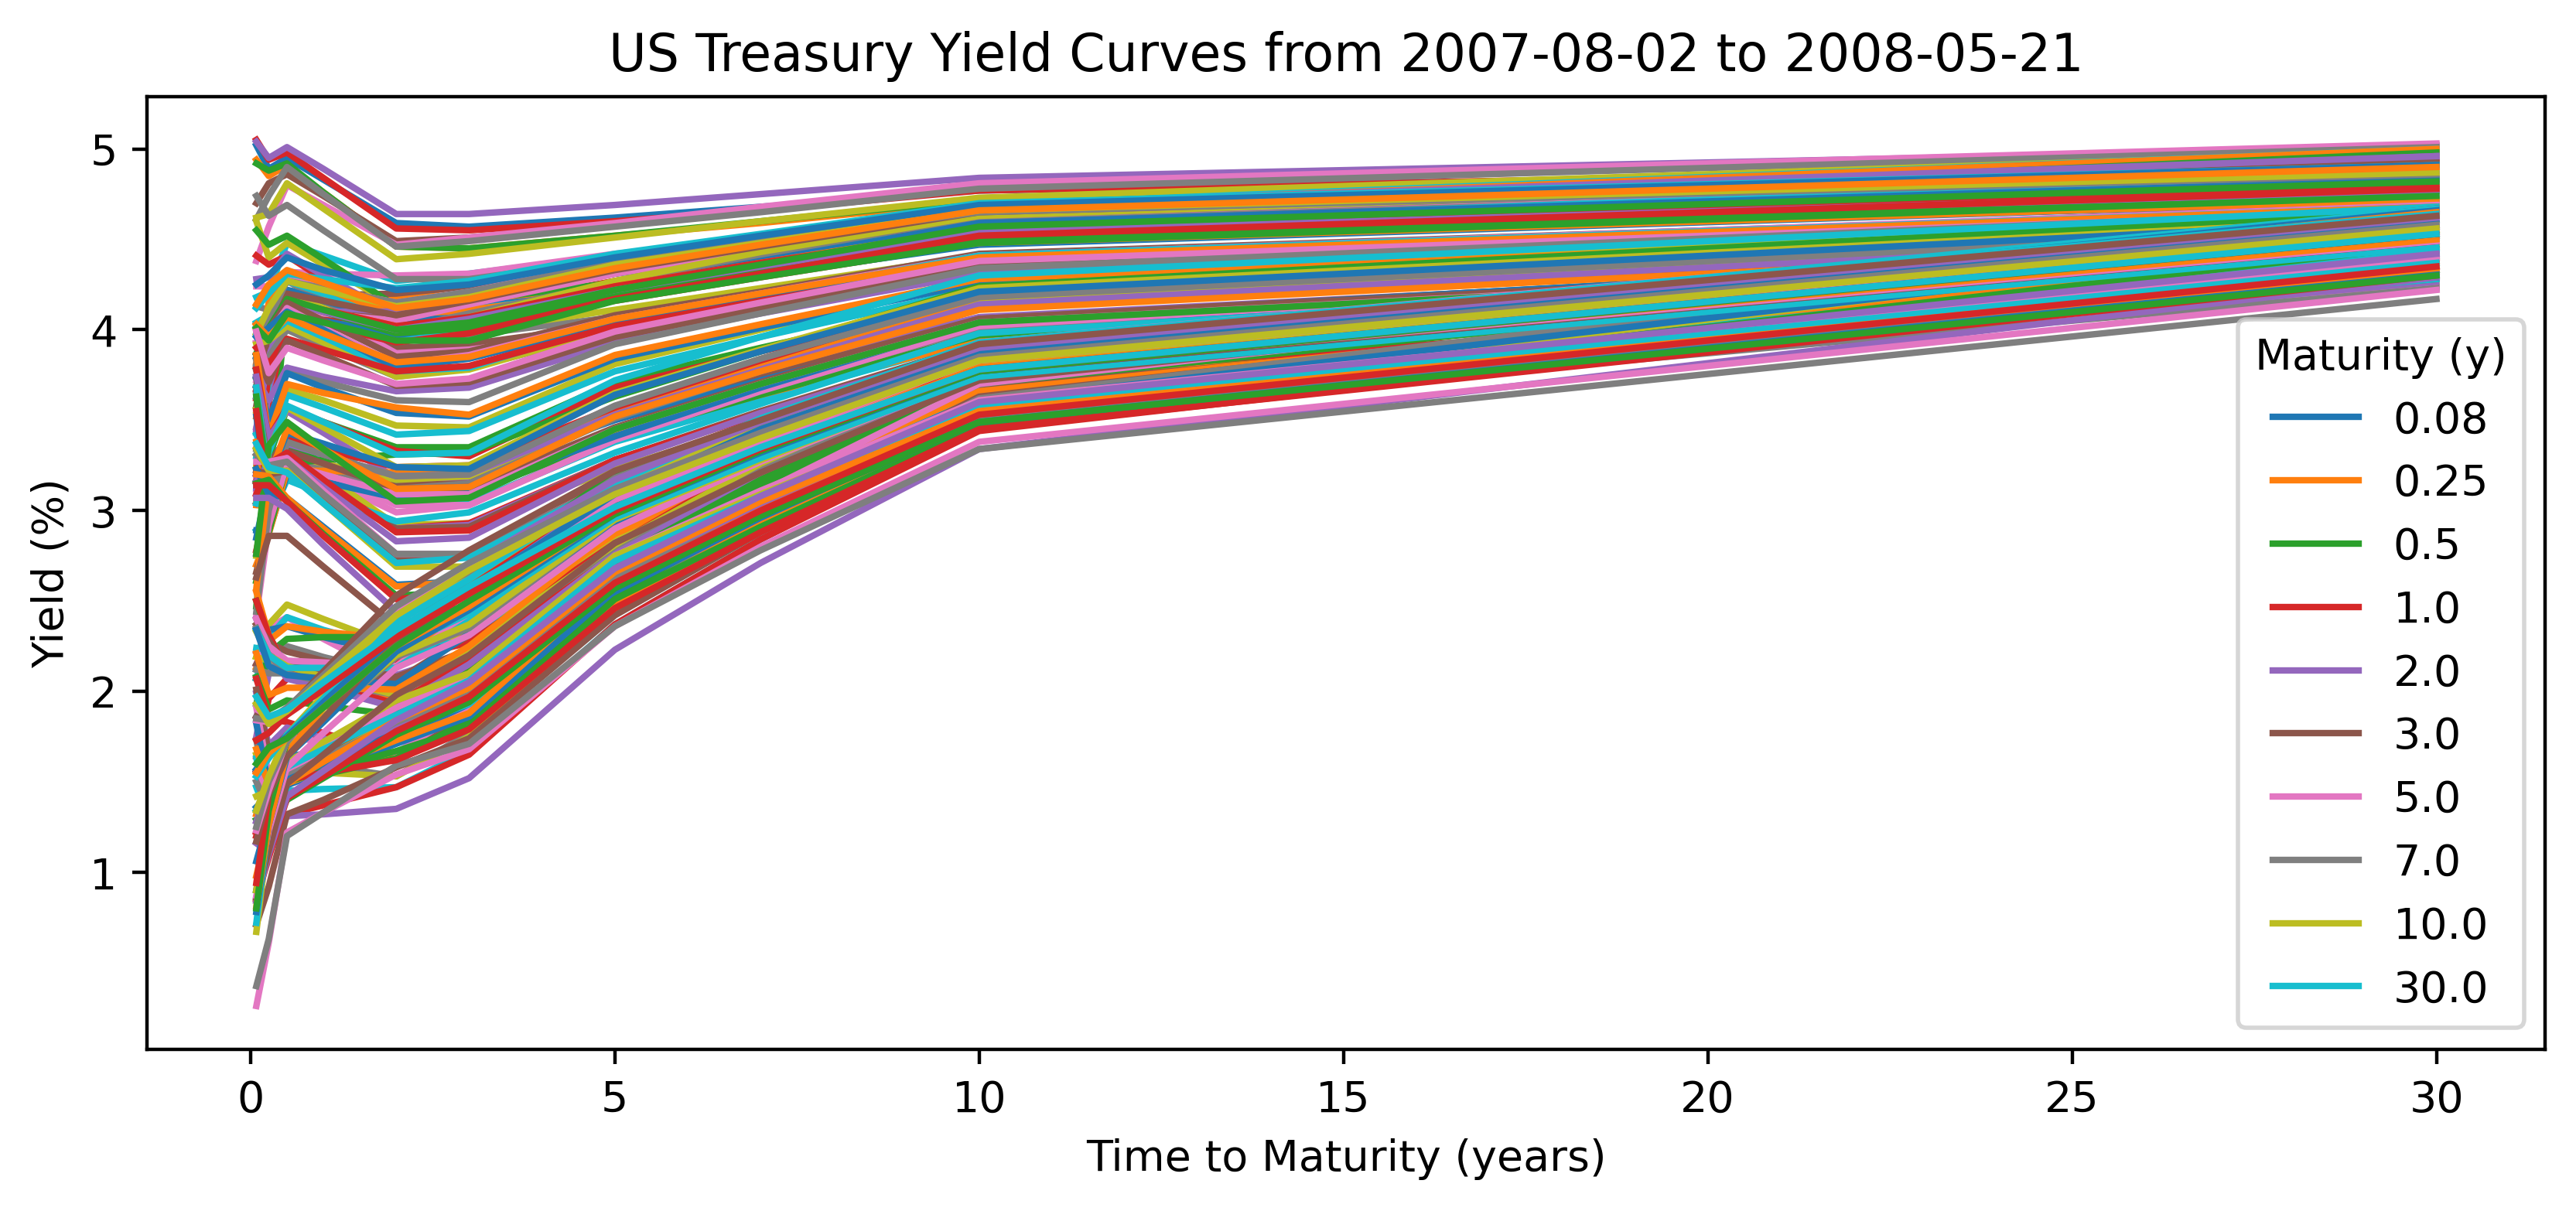

In [44]:
start_idx = 4400
num_curves = 200
end_idx = start_idx + num_curves

start_date: Timestamp = yield_curves.iloc[start_idx].name  # pyright: ignore[reportAssignmentType]
end_date: Timestamp = yield_curves.iloc[end_idx].name  # pyright: ignore[reportAssignmentType]
plt.plot(yield_curves.iloc[start_idx:end_idx].T)
plt.title(f"US Treasury Yield Curves from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
plt.xlabel("Time to Maturity (years)")
plt.ylabel("Yield (%)")
plt.legend(yield_curves.columns, title="Maturity (y)")
plt.show()

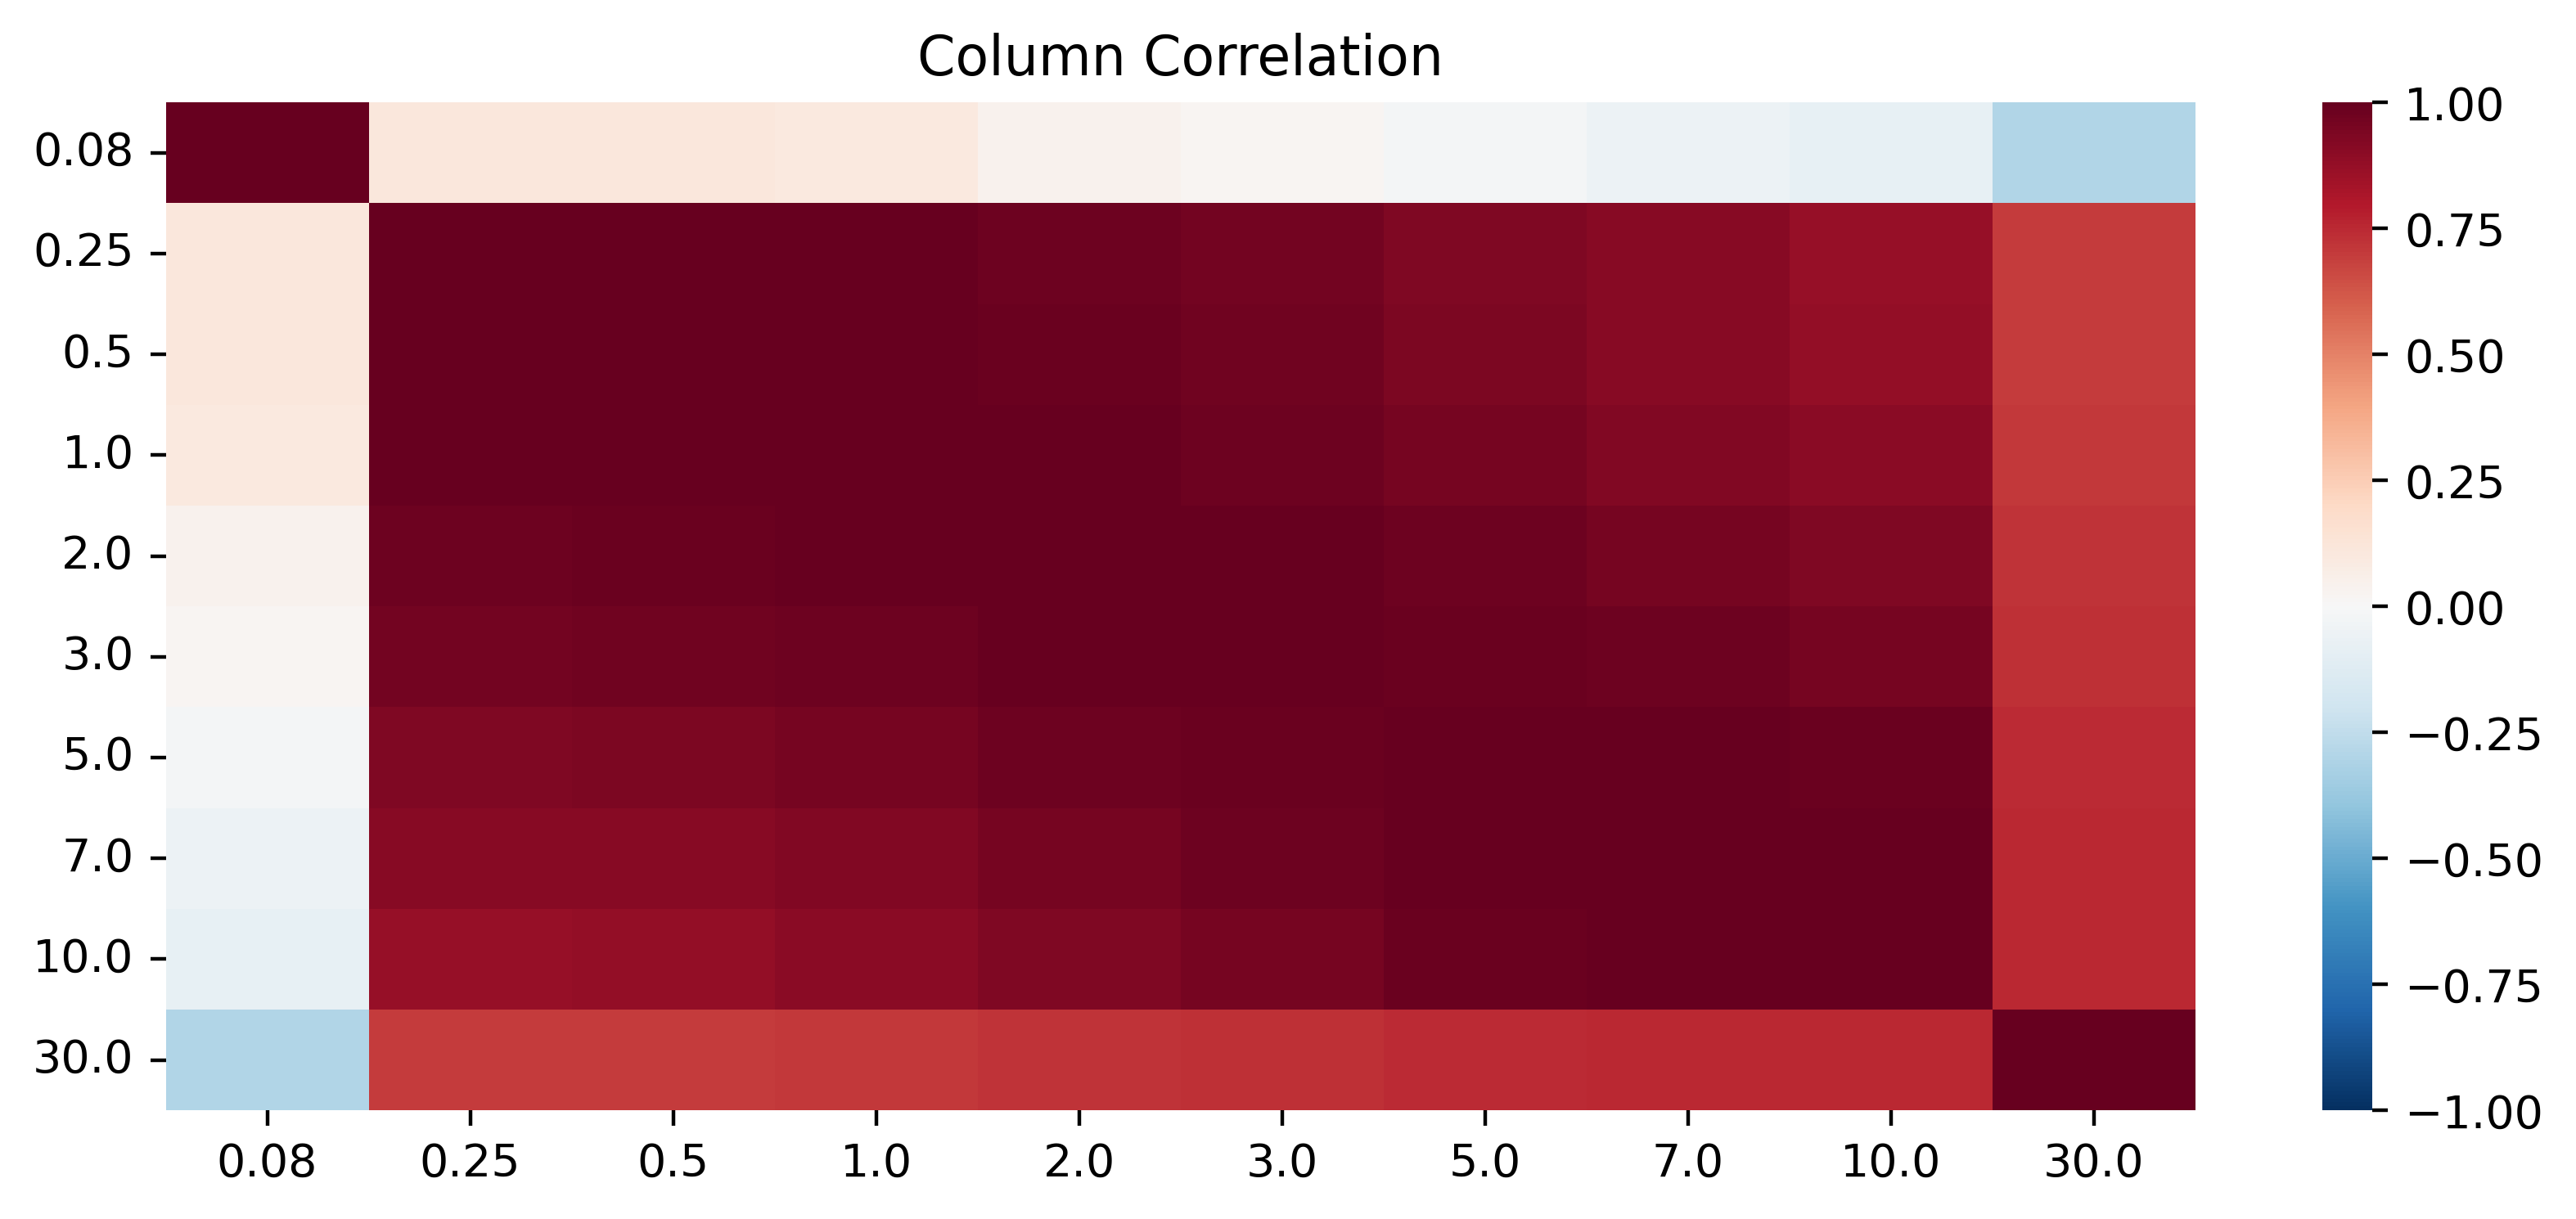

In [45]:
sns.heatmap(yield_curves.select_dtypes(include="number").corr(), cmap="RdBu_r", vmin=-1, vmax=1)
plt.title("Column Correlation")
plt.show()

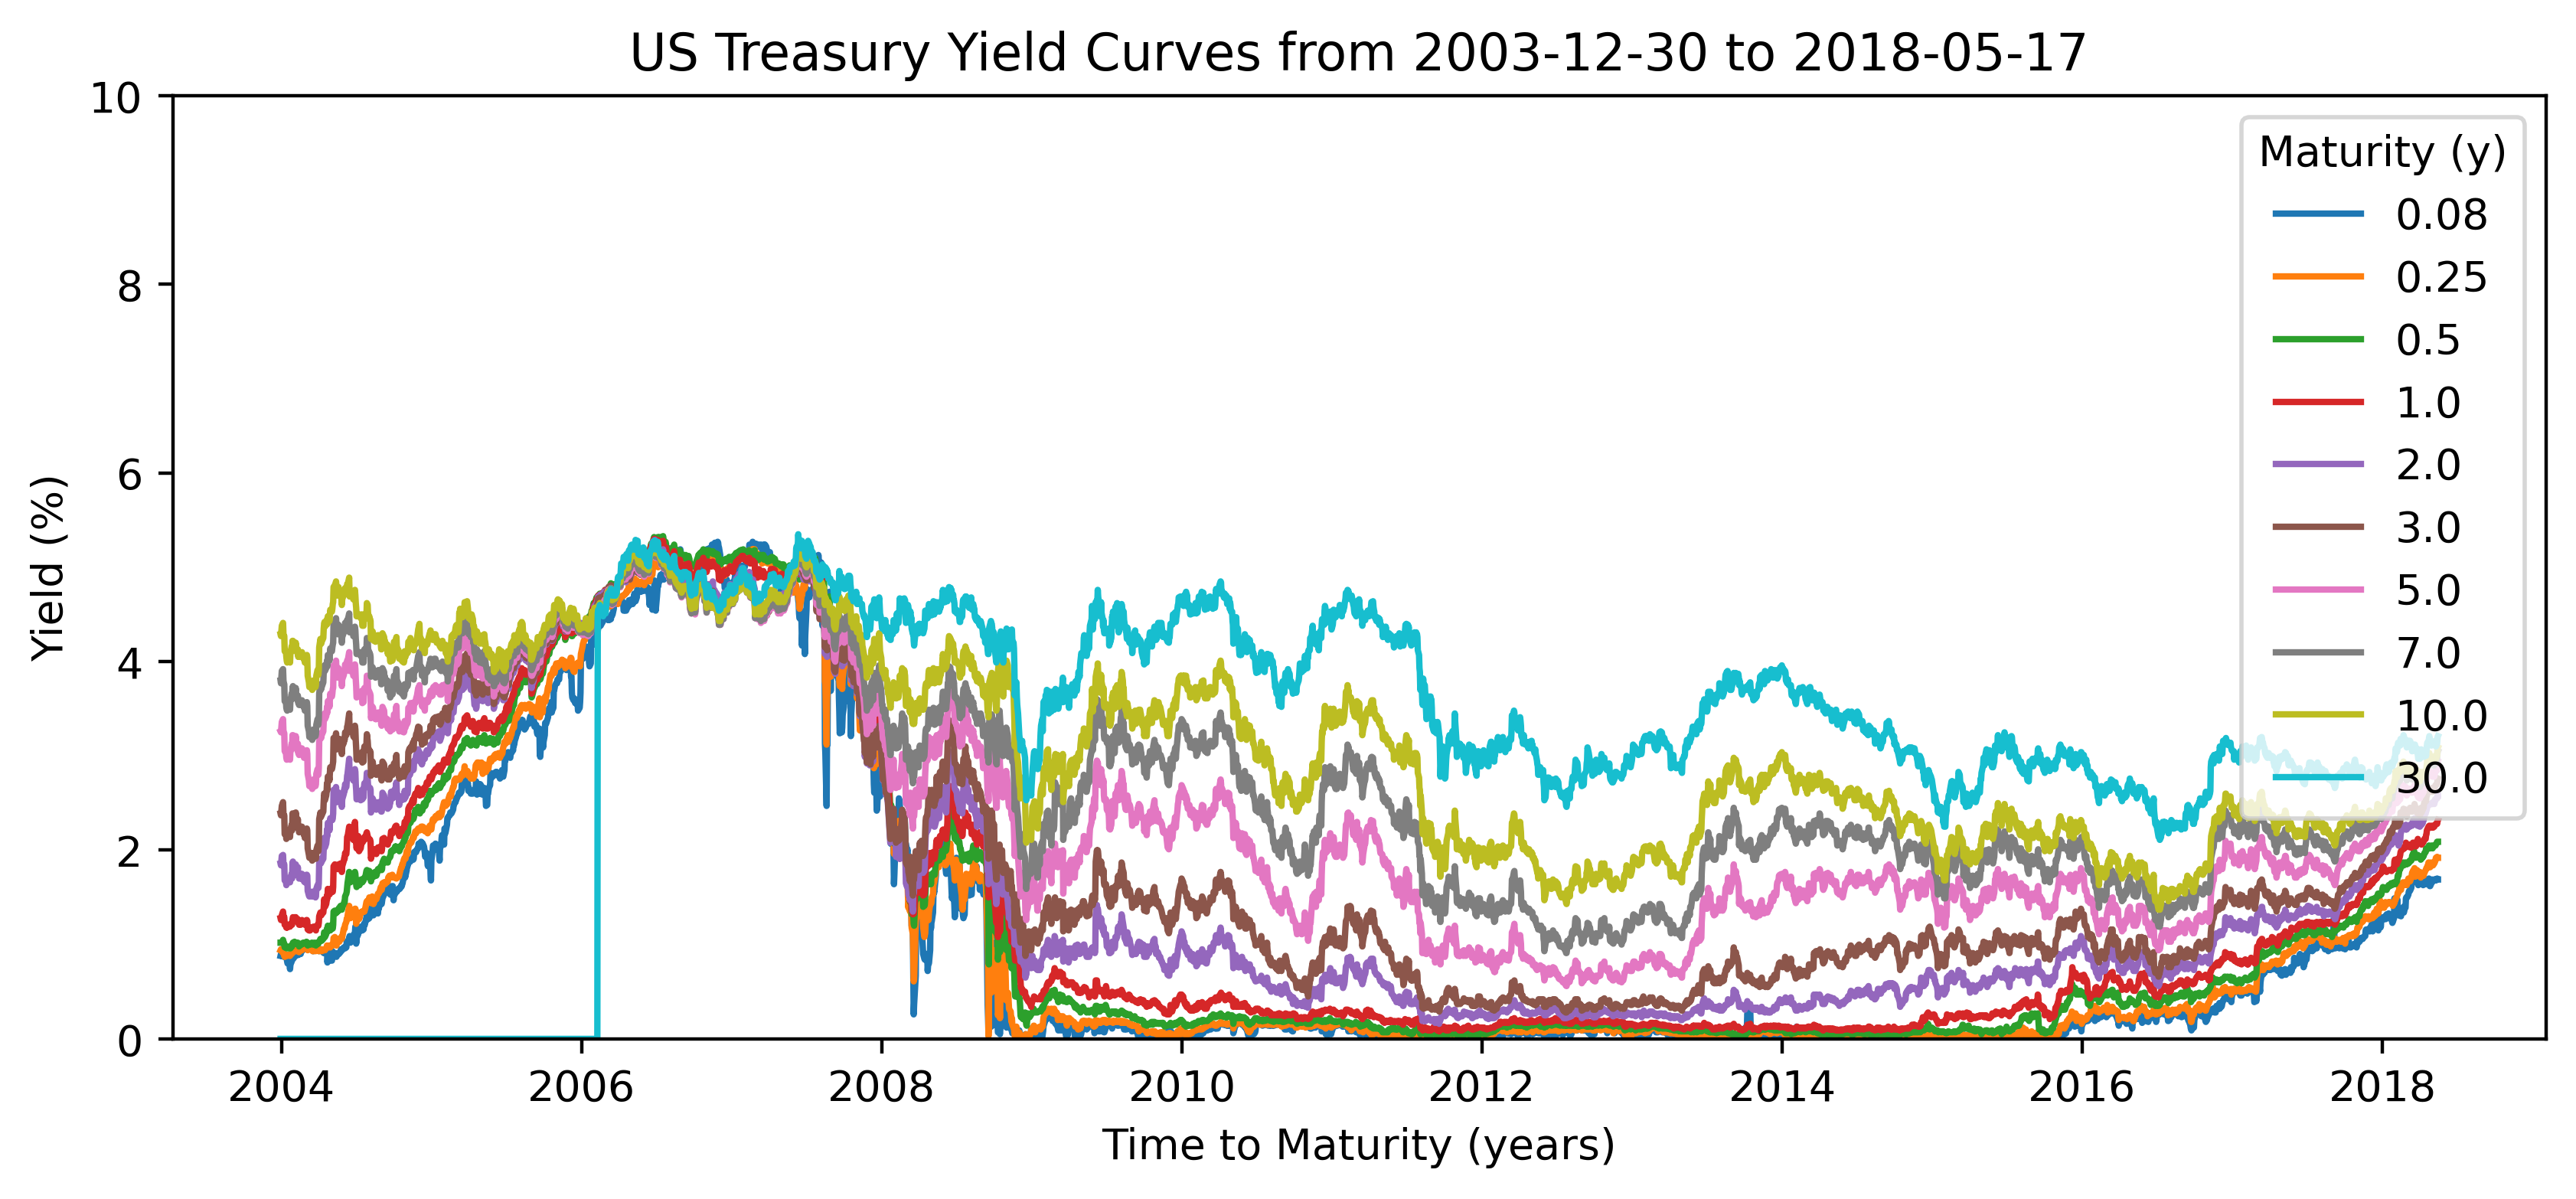

In [52]:
start_idx = 4400 - 900
num_curves = 3600
end_idx = start_idx + num_curves

start_date: Timestamp = yield_curves.iloc[start_idx].name  # pyright: ignore[reportAssignmentType]
end_date: Timestamp = yield_curves.iloc[end_idx].name  # pyright: ignore[reportAssignmentType]
plt.plot(yield_curves.iloc[start_idx:end_idx])
plt.title(f"US Treasury Yield Curves from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
plt.xlabel("Time to Maturity (years)")
plt.ylabel("Yield (%)")
plt.legend(yield_curves.columns, title="Maturity (y)")
plt.ylim(0, 10)
plt.show()

How do Yield Curves react to market shocks? What is the relationship between Yield Curve volatility and shocks?

Next information:
- Plot rolling vol, and rolling vol correlation
- MR property relative to RF rate according to literature models

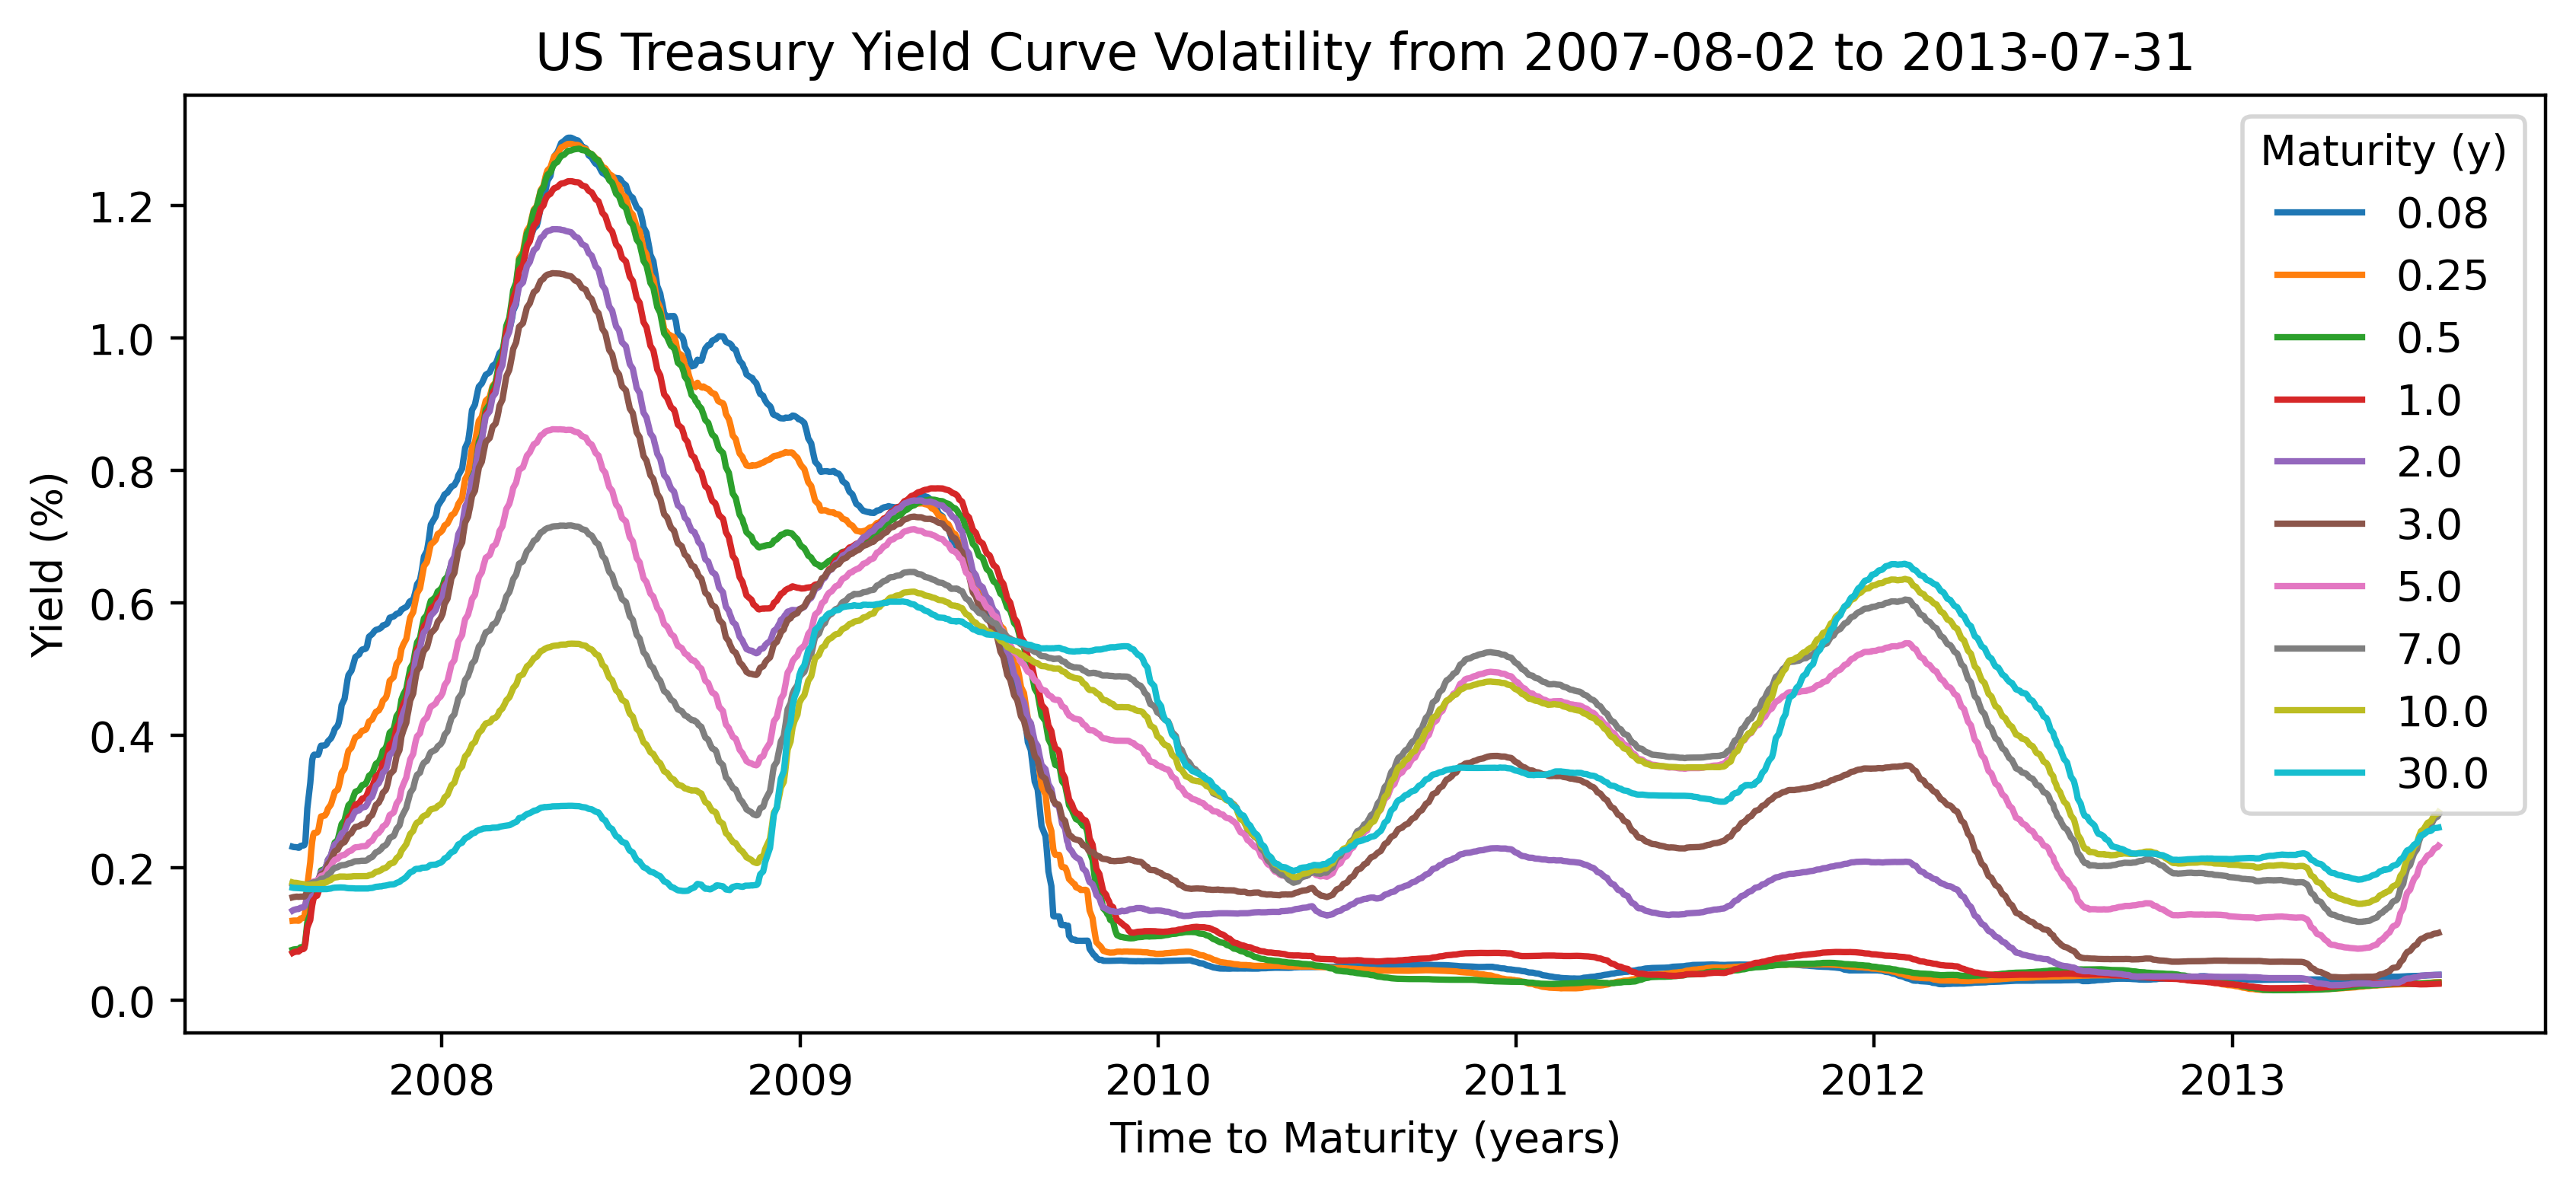

In [49]:
start_idx = 4400 
num_curves = 1500
end_idx = start_idx + num_curves
rolling_vol = yield_curves.rolling(252).std()

start_date: Timestamp = rolling_vol.iloc[start_idx].name  # pyright: ignore[reportAssignmentType]
end_date: Timestamp = rolling_vol.iloc[end_idx].name  # pyright: ignore[reportAssignmentType]
plt.plot(rolling_vol.iloc[start_idx:end_idx])
plt.title(f"US Treasury Yield Curve Volatility from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
plt.xlabel("Time to Maturity (years)")
plt.ylabel("Yield (%)")
plt.legend(yield_curves.columns, title="Maturity (y)")
plt.show()




## What is the structure of yields and volatility?

We can use Machine Learning in order to understand the structure of yield curves and volatility. We can compare whether or not they are similar


In [ ]:
from sklearn.decomposition import PCA

start_idx = 4400 - 900
num_curves = 3600
end_idx = start_idx + num_curves
X = yield_curves.iloc[start_idx:end_idx]
pca = PCA(n_components=3).fit(X)
scores = pca.transform(X)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].bar([1, 2, 3], pca.explained_variance_ratio_)
axes[0].set_xticks([1, 2, 3])
axes[0].set_xlabel("PC")
axes[0].set_ylabel("Explained variance ratio")
axes[0].set_title("Scree (yields)")
axes[1].plot(X.index, scores)
axes[1].legend(["PC1", "PC2", "PC3"])
axes[1].set_xlabel("Time")
axes[1].set_title("PCs over time (yields)")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.decomposition import PCA

rolling_vol = yield_curves.rolling(252).std()
start_idx = 4400
num_curves = 1500
end_idx = start_idx + num_curves
X = rolling_vol.iloc[start_idx:end_idx].dropna(axis=0)
pca = PCA(n_components=3).fit(X)
scores = pca.transform(X)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].bar([1, 2, 3], pca.explained_variance_ratio_)
axes[0].set_xticks([1, 2, 3])
axes[0].set_xlabel("PC")
axes[0].set_ylabel("Explained variance ratio")
axes[0].set_title("Scree (rolling vol)")
axes[1].plot(X.index, scores)
axes[1].legend(["PC1", "PC2", "PC3"])
axes[1].set_xlabel("Time")
axes[1].set_title("PCs over time (rolling vol)")
plt.tight_layout()
plt.show()

## Duration and Convexity
- Duration neutral trades
- Convexity neutral trades

- What is the importance of duration and convexity when hedging a position?

## Regime Detection with Machine Learning
Below, we will implement a clustering algorithm called SoftKMeans, which decides on market regimes. Oftentimes, people will experiment with this on equities. Can anyone discuss why this can lead to less reliable outcomes as opposed to yield curves?